# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset  
&nbsp; 2): Data Pre Processing  
&nbsp; 3): Transform the tabular data into images  
&nbsp; 4): Display the transformed images  
&nbsp; 5): Split the training and test set  

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this notebook, the database files were loaded from author's personal drive.

Some extra steps were added in comparison to Western-OC2-Lab original notebook.

In [2]:
#UNNCOMENT THIS CELL FOR COLAB EXECUTION WITH DRIVE

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
##EXCLUSIVE FOR COLAB
#from google.colab import drive
#drive.mount('/content')
link1 = 'https://drive.google.com/open?id=1ljO7auYN_doUFbUbPAP2HqcX6vzwgy1P' # RPM dataset
fluff, id = link1.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('RPM_dataset.csv')  
df1 = pd.read_csv('RPM_dataset.csv',names=['Timestamp','CAN ID','DLC','DATA[0]','DATA[1]','DATA[2]','DATA[3]','DATA[4]','DATA[5]','DATA[6]','DATA[7]','Label'])

In [4]:
##EXCLUSIVE FOR COLAB
#from google.colab import drive
#drive.mount('/content')
link2 = 'https://drive.google.com/open?id=1TBZXgZYhCvjoSwy6l7MNbuPcqQ5PBIVQ' # GEAR dataset
fluff, id = link2.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('gear_dataset.csv')  
df2 = pd.read_csv('gear_dataset.csv',names=['Timestamp','CAN ID','DLC','DATA[0]','DATA[1]','DATA[2]','DATA[3]','DATA[4]','DATA[5]','DATA[6]','DATA[7]','Label'])

In [5]:
##EXCLUSIVE FOR COLAB
#from google.colab import drive
#drive.mount('/content')
link3 = 'https://drive.google.com/open?id=1L9ICuJHr9ERtrJaTGXMWwgInE-Ak0VQv' # DoS dataset 
fluff, id = link3.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Fuzzy_dataset.csv')  
df3 = pd.read_csv('Fuzzy_dataset.csv',names=['Timestamp','CAN ID','DLC','DATA[0]','DATA[1]','DATA[2]','DATA[3]','DATA[4]','DATA[5]','DATA[6]','DATA[7]','Label'])

In [6]:
##EXCLUSIVE FOR COLAB
#from google.colab import drive
#drive.mount('/content')
link4 = 'https://drive.google.com/open?id=1w8N1D8uNQ5AIkZbr7P8N7ZaJdUQWJ-9Y' # Fuzzy dataset 
fluff, id = link4.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('DoS_dataset.csv')  
df4 = pd.read_csv('DoS_dataset.csv',names=['Timestamp','CAN ID','DLC','DATA[0]','DATA[1]','DATA[2]','DATA[3]','DATA[4]','DATA[5]','DATA[6]','DATA[7]','Label'])

## Data Preprocessing:

This step consists in five sub-steps of tabular data transformation:



*   Generate custom labels
*   Merge databases
*   Verify and remove null values
*   Convert data from hex to int
*   Drop undesired columns



  

* Generate custom labels for each attack:

In [7]:
df1['Label'].replace(['T'],'RPM',inplace=True)
df2['Label'].replace(['T'],'gear',inplace=True)
df3['Label'].replace(['T'],'DoS',inplace=True)
df4['Label'].replace(['T'],'Fuzzy',inplace=True)

* Merge databases

In [8]:
df = pd.concat([df1,df2,df3,df4]) #MERGE

* Verify null values:

In [9]:
df.isna().sum()

Timestamp         0
CAN ID            0
DLC               0
DATA[0]           0
DATA[1]           0
DATA[2]           0
DATA[3]      147211
DATA[4]      147211
DATA[5]      147211
DATA[6]      200662
DATA[7]      200665
Label        200665
dtype: int64

Evaluating null values we discover that some packets does not have values for fields DATA [3-7]. Accordingly to the authors (https://ocslab.hksecurity.net/Datasets/car-hacking-dataset) the field 'DLC' show us the size of data field in bytes. Let's take a look at count values for this field.

In [10]:
df.DLC.value_counts()

8    16368810
2      147211
5       53451
6           3
Name: DLC, dtype: int64

We have approximate 1.2% of packages with length less than 8 bytes. As this percentange does not represent a large slice of the database, we dropped all nan rows.

In [11]:
df.dropna(inplace=True)


In [12]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts()

R        14037293
RPM        654897
gear       597252
DoS        587521
Fuzzy      491847
Name: Label, dtype: int64

* Convert data from hex to int:




In [13]:
df['CAN ID'] = df['CAN ID'].apply(int, base=16)
df['DATA[0]'] = df['DATA[0]'].apply(int, base=16)
df['DATA[1]'] = df['DATA[1]'].apply(int, base=16)
df['DATA[2]'] = df['DATA[2]'].apply(int, base=16)
df['DATA[3]'] = df['DATA[3]'].apply(int, base=16)
df['DATA[4]'] = df['DATA[4]'].apply(int, base=16)
df['DATA[5]'] = df['DATA[5]'].apply(int, base=16)
df['DATA[6]'] = df['DATA[6]'].apply(int, base=16)
df['DATA[7]'] = df['DATA[7]'].apply(int, base=16)


* Drop Columns Timestamp and DLC:

In [14]:
df.drop(['Timestamp','DLC'],axis=1,inplace=True)

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [15]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [16]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [17]:
df.describe()

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
count,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07,1.636881e+07
mean,1.273415e+02,1.139431e+02,1.077358e+02,8.952790e+01,1.099116e+02,1.055121e+02,1.123215e+02,8.488314e+01,9.327051e+01
std,7.365949e+01,9.016205e+01,9.327004e+01,1.004776e+02,1.035923e+02,9.551478e+01,9.088196e+01,1.012057e+02,1.003229e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.687688e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.217568e+02,1.263514e+02,1.148649e+02,0.000000e+00,1.299249e+02,1.271171e+02,1.292868e+02,0.000000e+00,0.000000e+00
75%,1.900375e+02,1.928453e+02,1.928453e+02,1.987162e+02,1.910586e+02,1.927177e+02,1.899099e+02,1.915691e+02,1.910586e+02
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


All features are in the same scale of [0,255]

### Generate images for each class

In [18]:
df0=df[df['Label']=='R'].drop(['Label'],axis=1)
df1=df[df['Label']=='RPM'].drop(['Label'],axis=1)
df2=df[df['Label']=='gear'].drop(['Label'],axis=1)
df3=df[df['Label']=='DoS'].drop(['Label'],axis=1)
df4=df[df['Label']=='Fuzzy'].drop(['Label'],axis=1)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
%%time
# Generate 9*9 color images for class 0 (Normal)
count=0
ims = []

image_path = "train/0/" #/content/drive/MyDrive/deeplearning/CAN-IDS/
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=27: 
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 19min 42s, sys: 1min 11s, total: 20min 54s
Wall time: 20min 47s


In [21]:
%%time
# Generate 9*9 color images for class 1 (RPM spoofing)
count=0
ims = []

image_path = "train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=27: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 54.3 s, sys: 3.1 s, total: 57.4 s
Wall time: 57 s


In [22]:
%%time
# Generate 9*9 color images for class 2 (Gear spoofing)
count=0
ims = []

image_path = "train/2/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=27: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 53.3 s, sys: 3.48 s, total: 56.8 s
Wall time: 56.6 s


In [24]:
%%time
# Generate 9*9 color images for class 3 (DoS attack)
count=0
ims = []

image_path = "train/3/"
os.makedirs(image_path)


for i in range(0, len(df3)):  
    count=count+1
    if count<=27: 
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 48.9 s, sys: 3.48 s, total: 52.3 s
Wall time: 52 s


In [25]:
%%time
# Generate 9*9 color images for class 4 (Fuzzy attack)
count=0
ims = []

image_path = "train/4/"
os.makedirs(image_path)


for i in range(0, len(df4)):  
    count=count+1
    if count<=27: 
        im=df4.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 41.8 s, sys: 2.88 s, total: 44.7 s
Wall time: 44.4 s


### Display samples for each category

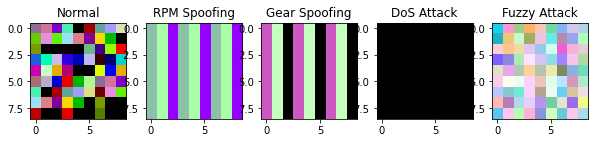

In [26]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train/0/27.png')
img2 = Image.open('./train/1/83.png')
img3 = Image.open('./train/2/27.png')
img4 = Image.open('./train/3/27.png')
img5 = Image.open('./train/4/27.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("RPM Spoofing")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Gear Spoofing")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("DoS Attack")
plt.subplot(1,5,5)
plt.imshow(img5)
plt.title("Fuzzy Attack")
plt.show()  # display it

## Split the training and test set 

In [27]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

584597


In [28]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [29]:
# The size of test set
Numbers

116919

In [30]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [31]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [32]:
%%time
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [33]:
%%time
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing


In [37]:
%%time
!cp -R train/ train2/

CPU times: user 893 ms, sys: 148 ms, total: 1.04 s
Wall time: 1min 20s
